### Import libraries

In [1]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

import hessians

### Explanations here

블록 여러개로 더 나누고 설명 적기

In [2]:
# 모델 정의
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out

In [3]:
np.random.seed(2)
input_dim = 5
output_dim = 1

num_samples = 1000
num_toxic_samples = 200
x = np.random.rand(num_samples, input_dim)

# Generate label data 
# where 300 samples are flipped and amplified.
y = 2 * x[:, 0:1] + 2 * x[:, 1:2] - 5 * x[:, 2:3] \
    + 1 * x[:, 3:4] - 3 * x[:, 4:5] + 1 \
    + np.random.randn(num_samples, 1)
y[:num_toxic_samples] = - y[:num_toxic_samples] * 5

# Randomly correlate each variables
h = np.random.uniform(size=(5,5))
h[:2, 2:] = 0
x = x @ h / 3

# Numpy array to torch.Tensor
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

### Linear regression for all samples.

In [4]:
model = LinearRegression(input_dim, output_dim)

# 손실함수 및 최적화 함수 정의
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 100
for _ in range(epochs):
    y_pred = model(x_tensor)
    loss = criterion(y_pred, y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Save initial weight and create copy of the model

In [5]:
initial_weight = model.linear.weight.view(-1).detach().numpy()
model_PIF = LinearRegression(input_dim, output_dim)
model_PIF.linear.weight = nn.Parameter(model.linear.weight)

model_FIF = LinearRegression(input_dim, output_dim)
model_FIF.linear.weight = nn.Parameter(model.linear.weight)

In [6]:
num_iter = 200
num_samples_per_iter = num_toxic_samples // num_iter
sample_indexes_list = np.linspace(0, num_iter * num_samples_per_iter,
                                  num_iter+1, dtype=int)[1:]

In [7]:
model_PIF_weights_list = np.zeros((num_iter+1, 2))
model_PIF_weights_list[0, :2] = initial_weight[:2]
for i, index in enumerate(sample_indexes_list):
    y_pred = model_PIF(x_tensor[index-num_samples_per_iter:index])
    sample_loss = criterion(y_pred,
                         y_tensor[index-num_samples_per_iter:index])
    total_loss = criterion(model_PIF(x_tensor[index:]), y_tensor[index:])
    
    sample_gradient = hessians.compute_gradient(sample_loss, model_PIF)
    total_hessian = hessians.compute_hessian(total_loss, model_PIF)
    partial_hessian = total_hessian[:, :2]
    
    # Compute PIF via direct computation
    # This is fast when the NN is small
    PIF = torch.linalg.inv(partial_hessian.T @ partial_hessian)\
        @ partial_hessian.T \
        @ sample_gradient
    PIF /= num_samples
    
    # Zero padding for adding PIF into model weight
    PIF = torch.cat((PIF.detach(), torch.zeros(3)))
    model_weight =  model_PIF.linear.weight.view(-1)
    w = torch.Tensor(model_weight + PIF).unsqueeze(0)
    model_PIF.linear.weight = nn.Parameter(w)
    
    # Add weights into the weight list
    model_PIF_weights_list[i+1, :] = w.view(-1).detach().numpy()[:2]

In [8]:
model_FIF_weights_list = np.zeros((num_iter+1, 2))
model_FIF_weights_list[0, :2] = initial_weight[:2]
for i, index in enumerate(sample_indexes_list):
    y_pred = model_FIF(x_tensor[index-num_samples_per_iter:index])
    sample_loss = criterion(y_pred,
                            y_tensor[index-num_samples_per_iter:index])
    total_loss = criterion(model_FIF(x_tensor[index:]),
                           y_tensor[index:])
    
    sample_gradient = hessians.compute_gradient(sample_loss, model_FIF)
    total_hessian = hessians.compute_hessian(total_loss, model_FIF)

    FIF = torch.inverse(total_hessian[:2, :2]) @ sample_gradient[:2]
    FIF /= num_samples
    
    # Zero padding for adding PIF into model weight
    FIF = torch.cat((FIF.detach(), torch.zeros(3)))
    model_weight =  model_FIF.linear.weight.view(-1)
    w = torch.Tensor(model_weight + PIF).unsqueeze(0)
    model_FIF.linear.weight = nn.Parameter(w)
    
    # Add weights into the weight list    
    model_FIF_weights_list[i+1, :] = w.view(-1).detach().numpy()[:2]

In [9]:
search_width = 100
w1_values = np.arange(-search_width, search_width, .5)
w2_values = np.arange(-search_width, search_width, .5)
loss_values = np.zeros((len(w1_values), len(w2_values)))

if os.path.isfile('loss_surface.npy'):
    loss_values = np.load('loss_surface.npy')
else:
    # Iterative loss surface computation
    model.linear.bias = nn.Parameter(torch.Tensor([1]))
    model_weight = model.linear.weight.view(-1)
    for i in range(len(w1_values)):
        for j in range(len(w2_values)):
            w = torch.Tensor([w1_values[i], w2_values[j], 
                              model_weight[2], model_weight[3],
                              model_weight[4]]).unsqueeze(0)
            model.linear.weight = nn.Parameter(w)
            y_pred = model(x_tensor[num_toxic_samples:])
            loss = criterion(y_pred, y_tensor[num_toxic_samples:])
            loss_values[i][j] = loss.item()

    # Save the loss surface
    np.save('loss_surface.npy', loss_values)

# Find the arguments for the optimal loss
min_index = np.unravel_index(np.argmin(loss_values), loss_values.shape)
map_center = (w1_values[min_index[0]], w2_values[min_index[1]])

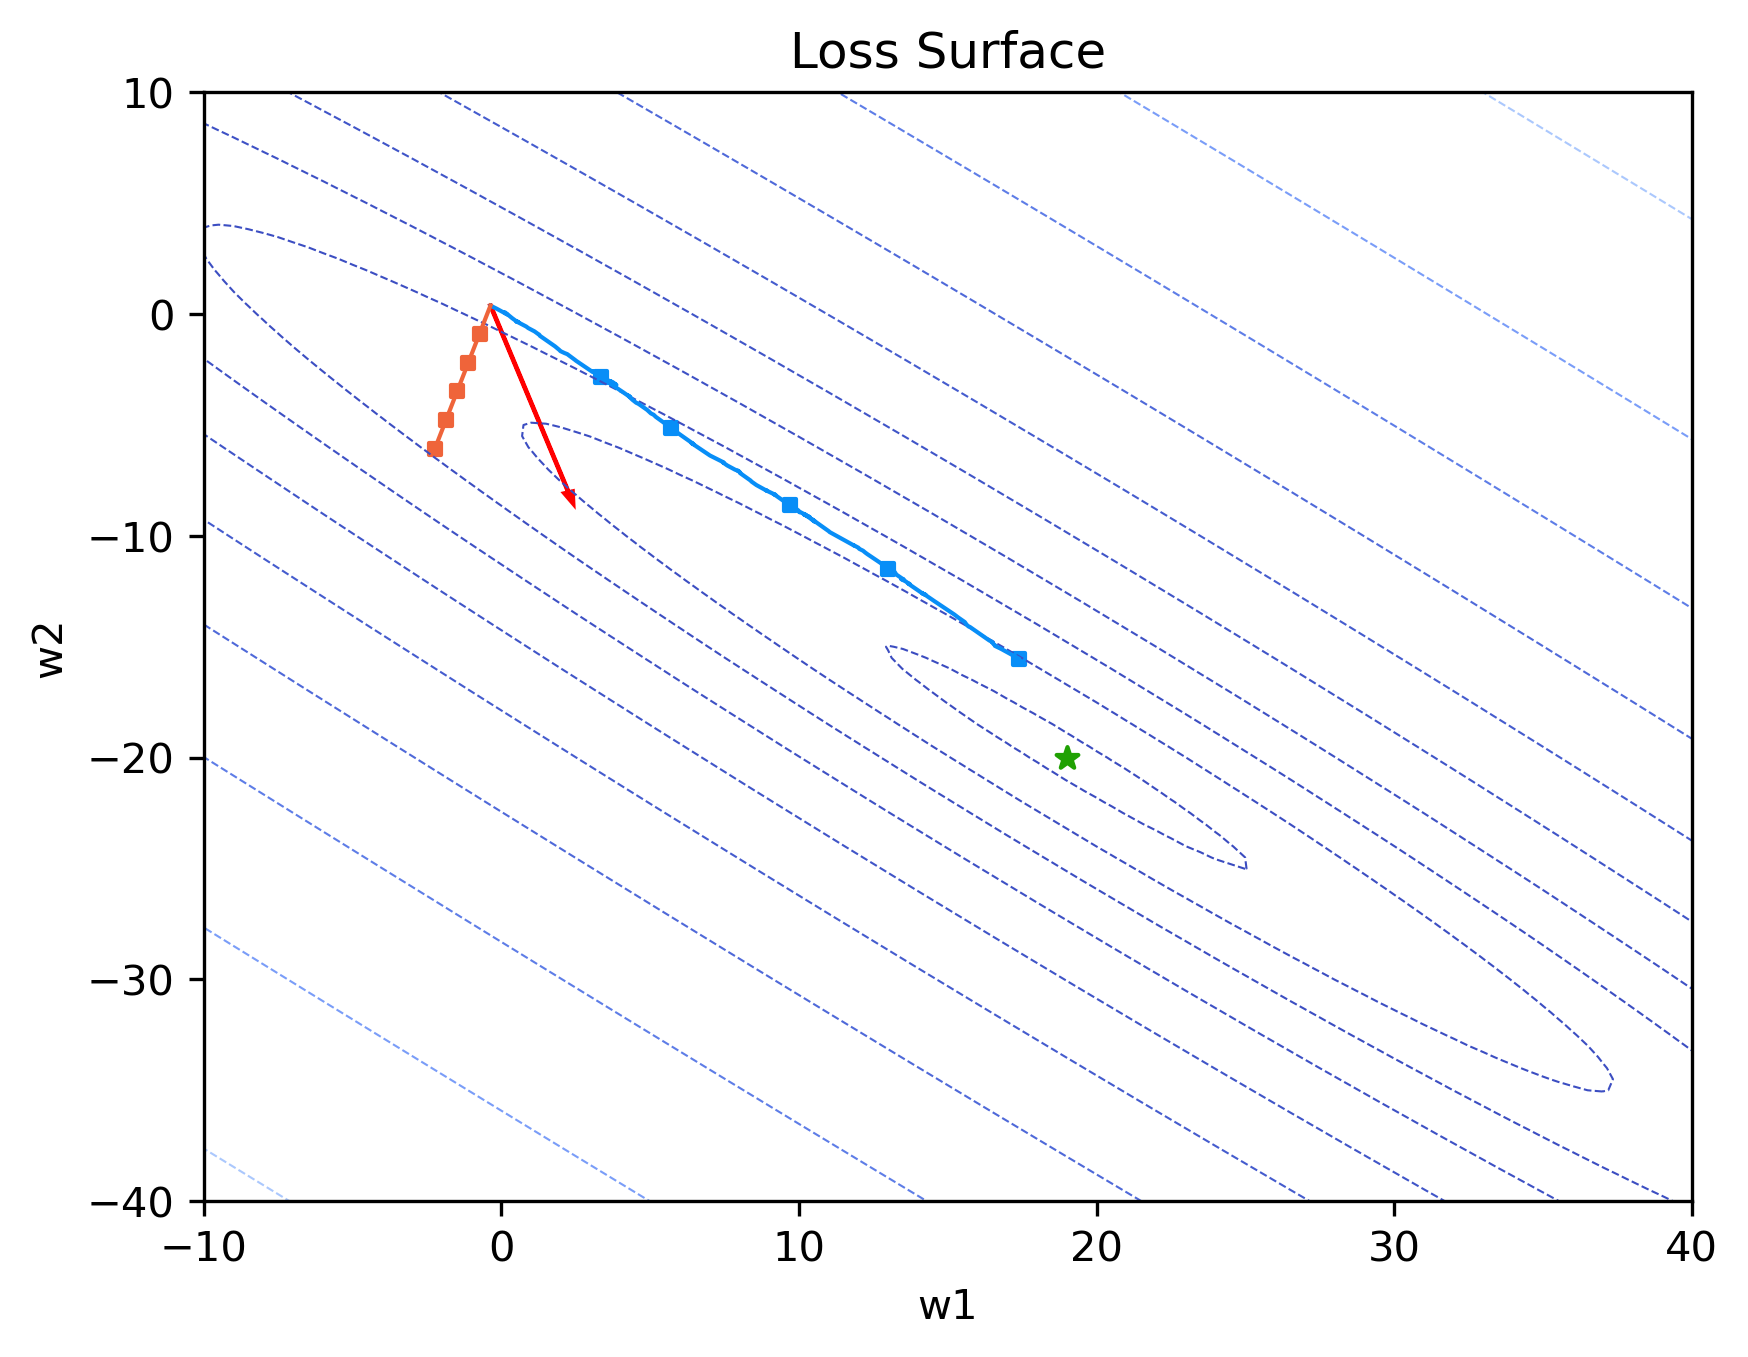

In [28]:
map_length_w1 = 40
map_length_w2 = 50
PIF_color = (0.03125   , 0.55859375, 0.96875)
FIF_color = (0.9375, 0.390625 , 0.2265625)

plt.rcParams['figure.dpi'] = 300
plt.title("Loss Surface")
plt.xlabel("w1")
plt.ylabel("w2")
plt.xlim(map_center[0] - map_length_w1, 
         map_center[0] + map_length_w1)
plt.ylim(map_center[1] - map_length_w2, 
         map_center[1] + map_length_w2)
plt.ylim(-40, 
         10)
plt.xlim(-10, 40)


X, Y = np.meshgrid(w1_values, w2_values)
levels = np.logspace(-1, 3, 18, base = 10)

cmap = plt.get_cmap('coolwarm') # colormap 지정
plt.contour(X, Y, loss_values.T, levels = levels, 
            cmap = cmap,
            linewidths = .5, linestyles = '--')

plt.scatter(map_center[0], map_center[1], 
            s = 30, color = (0.125, 0.63, 0.01), marker = '*')

total_loss = criterion(model(x_tensor), y_tensor)
sample_loss = criterion(model(x_tensor[:num_toxic_samples]).view(-1), 
                        y_tensor[:num_toxic_samples])

sample_gradient = hessians.compute_gradient(sample_loss, model)
total_hessian = hessians.compute_hessian(total_loss, model)

IF = - torch.inverse(total_hessian) @ sample_gradient
plt.arrow(initial_weight[0], initial_weight[1], 
          IF[0], IF[1], color='red', width=0.02,
          head_width=0.3, head_length=.55);

plt.plot(model_PIF_weights_list[:, 0], 
         model_PIF_weights_list[:, 1],
         '-', linewidth = 1., color = PIF_color)

plt.plot(model_FIF_weights_list[:, 0], 
         model_FIF_weights_list[:, 1],
         '-', linewidth = 1., color = FIF_color)

for i in range(num_iter):
    if (i + 1) % 40 == 0:
        plt.scatter(model_FIF_weights_list[i, 0], 
                    model_FIF_weights_list[i, 1],
                    s = 7, color = FIF_color, 
                    marker = 's')
        plt.scatter(model_PIF_weights_list[i, 0], 
                    model_PIF_weights_list[i, 1], 
                    s = 7, color = PIF_color, 
                    marker = 's')


plt.savefig('figures/Figure 1.eps', format='eps')
plt.show()